**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Intro to Random Forests

## About this course

### Teaching approach

This course is being taught by Jeremy Howard, and was developed by Jeremy along with Rachel Thomas. Rachel has been dealing with a life-threatening illness so will not be teaching as originally planned this year.

Jeremy has worked in a number of different areas - feel free to ask about anything that he might be able to help you with at any time, even if not directly related to the current topic:

- Management consultant (McKinsey; AT Kearney)
- Self-funded startup entrepreneur (Fastmail: first consumer synchronized email; Optimal Decisions: first optimized insurance pricing)
- VC-funded startup entrepreneur: (Kaggle; Enlitic: first deep-learning medical company)

I'll be using a *top-down* teaching method, which is different from how most math courses operate.  Typically, in a *bottom-up* approach, you first learn all the separate components you will be using, and then you gradually build them up into more complex structures.  The problems with this are that students often lose motivation, don't have a sense of the "big picture", and don't know what they'll need.

If you took the fast.ai deep learning course, that is what we used.  You can hear more about my teaching philosophy [in this blog post](http://www.fast.ai/2016/10/08/teaching-philosophy/) or [in this talk](https://vimeo.com/214233053).

Harvard Professor David Perkins has a book, [Making Learning Whole](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719) in which he uses baseball as an analogy.  We don't require kids to memorize all the rules of baseball and understand all the technical details before we let them play the game.  Rather, they start playing with a just general sense of it, and then gradually learn more rules/details as time goes on.

All that to say, don't worry if you don't understand everything at first!  You're not supposed to.  We will start using some "black boxes" such as random forests that haven't yet been explained in detail, and then we'll dig into the lower level details later.

To start, focus on what things DO, not what they ARE.

### Your practice

People learn by:
1. **doing** (coding and building)
2. **explaining** what they've learned (by writing or helping others)

Therefore, we suggest that you practice these skills on Kaggle by:
1. Entering competitions (*doing*)
2. Creating Kaggle kernels (*explaining*)

It's OK if you don't get good competition ranks or any kernel votes at first - that's totally normal! Just try to keep improving every day, and you'll see the results over time.

To get better at technical writing, study the top ranked Kaggle kernels from past competitions, and read posts from well-regarded technical bloggers. Some good role models include:

- [Peter Norvig](http://nbviewer.jupyter.org/url/norvig.com/ipython/ProbabilityParadox.ipynb) (more [here](http://norvig.com/ipython/))
- [Stephen Merity](https://smerity.com/articles/2017/deepcoder_and_ai_hype.html)
- [Julia Evans](https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture) (more [here](https://jvns.ca/blog/2014/08/12/what-happens-if-you-write-a-tcp-stack-in-python/))
- [Julia Ferraioli](http://blog.juliaferraioli.com/2016/02/exploring-world-using-vision-twilio.html)
- [Edwin Chen](http://blog.echen.me/2014/10/07/moving-beyond-ctr-better-recommendations-through-human-evaluation/)
- [Slav Ivanov](https://blog.slavv.com/picking-an-optimizer-for-style-transfer-86e7b8cba84b) (fast.ai student)
- [Brad Kenstler](https://hackernoon.com/non-artistic-style-transfer-or-how-to-draw-kanye-using-captain-picards-face-c4a50256b814) (fast.ai and USF MSAN student)

### Books

The more familiarity you have with numeric programming in Python, the better. If you're looking to improve in this area, we strongly suggest Wes McKinney's [Python for Data Analysis, 2nd ed](https://www.amazon.com/Python-Data-Analysis-Wrangling-IPython/dp/1491957662/ref=asap_bc?ie=UTF8).

For machine learning with Python, we recommend:

- [Introduction to Machine Learning with Python](https://www.amazon.com/Introduction-Machine-Learning-Andreas-Mueller/dp/1449369413): From one of the scikit-learn authors, which is the main library we'll be using
- [Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow, 2nd Edition](https://www.amazon.com/Python-Machine-Learning-scikit-learn-TensorFlow/dp/1787125939/ref=dp_ob_title_bk): New version of a very successful book. A lot of the new material however covers deep learning in Tensorflow, which isn't relevant to this course
- [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/ref=pd_lpo_sbs_14_t_0?_encoding=UTF8&psc=1&refRID=MBV2QMFH3EZ6B3YBY40K)


### Syllabus in brief

Depending on time and class interests, we'll cover something like (not necessarily in this order):

- Train vs test
  - Effective validation set construction
- Trees and ensembles
  - Creating random forests
  - Interpreting random forests
- What is ML?  Why do we use it?
  - What makes a good ML project?
  - Structured vs unstructured data
  - Examples of failures/mistakes
- Feature engineering
  - Domain specific - dates, URLs, text
  - Embeddings / latent factors
- Regularized models trained with SGD
  - GLMs, Elasticnet, etc (NB: see what James covered)
- Basic neural nets
  - PyTorch
  - Broadcasting, Matrix Multiplication
  - Training loop, backpropagation
- KNN
- CV / bootstrap (Diabetes data set?)
- Ethical considerations

Skip:

- Dimensionality reduction
- Interactions
- Monitoring training
- Collaborative filtering
- Momentum and LR annealing


## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *




In [3]:
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

/usr/local/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [17]:
import torch

In [18]:
torch.cuda.device(0)


In [19]:
torch.cuda.is_available()

True

In [20]:
PATH = "../../../covid/"

In [21]:
!ls {PATH}

Train.csv


# Introduction to *Blue Book for Bulldozers*

## About...

### ...our teaching

At fast.ai we have a distinctive [teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653).  This is different from how most traditional math & technical courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

### ...our approach to machine learning

Most machine learning courses will throw at you dozens of different algorithms, with a brief technical description of the math behind them, and maybe a toy example. You're left confused by the enormous range of techniques shown and have little practical understanding of how to apply them.

The good news is that modern machine learning can be distilled down to a couple of key techniques that are of very wide applicability. Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

- *Ensembles of decision trees* (i.e. Random Forests and Gradient Boosting Machines), mainly for structured data (such as you might find in a database table at most companies)
- *Multi-layered neural networks learnt with SGD* (i.e. shallow and/or deep learning), mainly for unstructured data (such as audio, vision, and natural language)

In this course we'll be doing a deep dive into random forests, and simple models learnt with SGD. You'll be learning about gradient boosting and deep learning in part 2.

### ...this dataset

We will be looking at the Blue Book for Bulldozers Kaggle Competition: "The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuration.  The data is sourced from auction result postings and includes information on usage and equipment configurations."

This is a very common type of dataset and prediciton problem, and similar to what you may see in your project or workplace.

### ...Kaggle Competitions

Kaggle is an awesome resource for aspiring data scientists or anyone looking to improve their machine learning skills.  There is nothing like being able to get hands-on practice and receiving real-time feedback to help you improve your skills.

Kaggle provides:

1. Interesting data sets
2. Feedback on how you're doing
3. A leader board to see what's good, what's possible, and what's state-of-art.
4. Blog posts by winning contestants share useful tips and techniques.

## The data

### Look at the data

Kaggle provides info about some of the fields of our dataset; on the [Kaggle Data info](https://www.kaggle.com/c/bluebook-for-bulldozers/data) page they say the following:

For this competition, you are predicting the sale price of bulldozers sold at auctions. The data for this competition is split into three parts:

- **Train.csv** is the training set, which contains data through the end of 2011.
- **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012. You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
- **Test.csv** is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

The key fields are in train.csv are:

- SalesID: the unique identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

*Question*

What stands out to you from the above description?  What needs to be true of our training and validation sets?

In [22]:
!head '{PATH}Train.csv'

parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability
6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQ

In [23]:
name = 'Hassan'

In [13]:
f'Hello{name}'

'HelloHassan'

In [14]:
age =23

In [16]:
#pandas f'{PATH}Train.csv'lets use csv file

In [17]:
f'{PATH}Train.csv'

'data/bulldozers/Train.csv'

In [18]:
#rows

In [10]:
!wc -l '{PATH}Train.csv'

20313 ../../../covid/Train.csv


In [13]:
!cat '{PATH}Train.csv'


parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability
6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQ

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



DLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDPPEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVV

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

6VYB_A,MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNEVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPSGAGSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAIS

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False)

In any sort of data science work, it's **important to look at your data**, to make sure you understand the format, how it's stored, what type of values it holds, etc. Even if you've read descriptions about your data, the actual data may not be what you expect.

In [26]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [27]:
#transpose column as rows 

In [28]:
display_all(df_raw.tail().T)

20307  \
parent_protein_id                                               6VYB_A   
protein_seq          MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...   
start_position                                                    1258   
end_position                                                      1277   
peptide_seq                                       YVRKDGEWVLLSTFLGHHHH   
chou_fasman                                                      0.947   
emini                                                            0.406   
kolaskar_tongaonkar                                              1.063   
parker                                                           0.155   
isoelectric_point                                              6.03595   
aromaticity                                                    0.10929   
hydrophobicity                                               -0.138642   
stability                                                      31.3776   

                                                                 20308  \
parent_protein_id                                               6VYB_A   
protein_seq          MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...   
start_position                                                    1259   
end_position                                                      1278   
peptide_seq                                       VRKDGEWVLLSTFLGHHHHH   
chou_fasman                                                      0.937   
emini                                                            0.353   
kolaskar_tongaonkar                                              1.061   
parker                                                           0.355   
isoelectric_point                                              6.03595   
aromaticity                                                    0.10929   
hydrophobicity                                               -0.138642   
stability                                                      31.3776   

                                                                 20309  \
parent_protein_id                                               6VYB_A   
protein_seq          MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...   
start_position                                                    1260   
end_position                                                      1279   
peptide_seq                                       RKDGEWVLLSTFLGHHHHHH   
chou_fasman                                                       0.96   
emini                                                            0.647   
kolaskar_tongaonkar                                              1.047   
parker                                                           0.645   
isoelectric_point                                              6.03595   
aromaticity                                                    0.10929   
hydrophobicity                                               -0.138642   
stability                                                      31.3776   

                                                                 20310  \
parent_protein_id                                               6VYB_A   
protein_seq          MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...   
start_position                                                    1261   
end_position                                                      1280   
peptide_seq                                       KDGEWVLLSTFLGHHHHHHH   
chou_fasman                                                       0.96   
emini                                                            0.449   
kolaskar_tongaonkar                                              1.058   
parker                                                            0.54   
isoelectric_point                                              6.03595   
aromaticity                                                    0.10929   
hydrophobicity                                               -0.13

In [29]:
display_all(df_raw.describe(include='all').T)

count unique  \
parent_protein_id    20312      1   
protein_seq          20312      1   
start_position       20312    NaN   
end_position         20312    NaN   
peptide_seq          20312  20305   
chou_fasman          20312    NaN   
emini                20312    NaN   
kolaskar_tongaonkar  20312    NaN   
parker               20312    NaN   
isoelectric_point    20312    NaN   
aromaticity          20312    NaN   
hydrophobicity       20312    NaN   
stability            20312    NaN   

                                                                   top   freq  \
parent_protein_id                                               6VYB_A  20312   
protein_seq          MGILPSPGMPALLSLVSLLSVLLMGCVAETGTQCVNLTTRTQLPPA...  20312   
start_position                                                     NaN    NaN   
end_position                                                       NaN    NaN   
peptide_seq                                                      HHHHH      4   
chou_fasman                                                        NaN    NaN   
emini                                                              NaN    NaN   
kolaskar_tongaonkar                                                NaN    NaN   
parker                                                             NaN    NaN   
isoelectric_point                                                  NaN    NaN   
aromaticity                                                        NaN    NaN   
hydrophobicity                                                     NaN    NaN   
stability                                                          NaN    NaN   

                         mean          std       min       25%       50%  \
parent_protein_id         NaN          NaN       NaN       NaN       NaN   
protein_seq               NaN          NaN       NaN       NaN       NaN   
start_position        635.258      366.496         1       318       635   
end_position          646.742      366.496         5       329       647   
peptide_seq               NaN          NaN       NaN       NaN       NaN   
chou_fasman           1.00305     0.106191     0.596     0.935     1.001   
emini                0.999996      1.28788     0.003     0.272     0.587   
kolaskar_tongaonkar   1.03726    0.0466768     0.837     1.008     1.035   
parker                1.33479      1.53936    -7.317     0.453     1.406   
isoelectric_point     6.03595            0   6.03595   6.03595   6.03595   
aromaticity           0.10929  3.02682e-14   0.10929   0.10929   0.10929   
hydrophobicity      -0.138642  3.21973e-14 -0.138642 -0.138642 -0.138642   
stability             31.3776  1.30743e-11   31.3776   31.3776   31.3776   

                          75%       max  
parent_protein_id         NaN       NaN  
protein_seq               NaN       NaN  
start_position            953      1277  
end_position              964      1281  
peptide_seq               NaN       NaN  
chou_fasman             1.067     1.538  
emini                   1.222    18.298  
kolaskar_tongaonkar     1.064     1.282  
parker                  2.289       7.3  
isoelectric_point     6.03595   6.03595  
aromaticity           0.10929   0.10929  
hydrophobicity      -0.138642 -0.138642  
stability             31.3776   31.3776

It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

### Initial processing

In [27]:
RandomForestRegressor

sklearn.ensemble._forest.RandomForestRegressor

In [29]:
#classifier for categorical and regressor for continuius

In [31]:
m = RandomForestClassifier(n_jobs=-1) #because we are using continious variable to predict
#other wise classifier used for category 

# The following code is supposed to fail due to string values in the input data
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

# m.fit(idependent, dependent )

KeyError: "['SalePrice'] not found in axis"

This dataset contains a mix of **continuous** and **categorical** variables.

The following method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.  You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.

In [ ]:
df_raw.saledate

In [ ]:
??add_datepart

In [ ]:
fld =df_raw.saledate

In [ ]:
fld.dt.day

In [31]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

The categorical variables are currently stored as strings, which is inefficient, and doesn't provide the numeric coding required for a random forest. Therefore we call `train_cats` to convert strings to pandas categories.

In [32]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [33]:
df_raw.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246  11.097410     999089     3157         121           3.0      2004   
1  1139248  10.950807     117657       77         121           3.0      1996   
2  1139249   9.210340     434808     7009         121           3.0      2001   
3  1139251  10.558414    1026470      332         121           3.0      2001   
4  1139253   9.305651    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter UsageBand fiModelDesc  ... saleDay saleDayofweek  \
0                      68.0       Low        521D  ...      16             3   
1                    4640.0       Low      950FII  ...      26             4   
2                    2838.0      High         226  ...      26             3   
3                    3486.0      High    PC120-6E  ...      19             3   
4                     722.0    Medium        S175  ...      23             3   

  saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end  \
0           320            False              False              False   
1            86            False              False              False   
2            57            False              False              False   
3           139            False              False              False   
4           204            False              False              False   

  saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed  
0                False           False             False  1163635200  
1                False           False             False  1080259200  
2                False           False             False  1077753600  
3                False           False             False  1305763200  
4                False           False             False  1248307200  

[5 rows x 65 columns]

In [34]:
#See USAGE BAND Need to Categories to Integers

In [35]:
??train_cats 

## Remember Test Set Maapping should be same as Training Set mapping
### Train_cats Creates categorical variable for df columns having type string

##### Two make the same training and testing mapping same ??apply_cats Used

In [37]:
train_cats(df_raw)

In [38]:
#Let say for training it assign 3 for high category
#For testing there can be another

In [39]:
df_raw.UsageBand.cat.#press tabs

SyntaxError: invalid syntax (<ipython-input-39-d62d5230f8ee>, line 1)

#We can specify the order to use for categorical variables if we wish:

In [40]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [41]:
#ReOrdering categories
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'],ordered=True,inplace = True)

In [42]:
df_raw.UsageBand.cat.codes

0         2
1         2
2         0
3         0
4         1
         ..
401120   -1
401121   -1
401122   -1
401123   -1
401124   -1
Length: 401125, dtype: int8

In [43]:
#-1 for missing

In [44]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

Normally, pandas will continue displaying the text categories, while treating them as numerical data internally. Optionally, we can replace the text categories with numbers, which will make this variable non-categorical, like so:.

In [45]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

We're still not quite done - for instance we have lots of missing values, which we can't pass directly to a random forest.

In [46]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [47]:
os.makedirs('tmp', exist_ok=True)
#Saving into ram
df_raw.to_feather('tmp/bulldozers-raw')

### Pre-processing

In the future we can simply read it from this fast format.

In [48]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [49]:
??proc_df

In [50]:
#if missing value is numeric replace it with new boolean column_na
#(1 means missed 0 means not missed  ) plus original column with median value
#categories not need to handle missing assigned  codes = codes +1 
#so missing value by default was zero now it becomes 1 

In [51]:
??fix_missing

In [52]:
df, y, nas = proc_df(df_raw, 'SalePrice')



We now have something we can pass to a random forest!

In [43]:
df.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246     999089     3157         121           3.0      2004   
1  1139248     117657       77         121           3.0      1996   
2  1139249     434808     7009         121           3.0      2001   
3  1139251    1026470      332         121           3.0      2001   
4  1139253    1057373    17311         121           3.0      2007   

   MachineHoursCurrentMeter  UsageBand  fiModelDesc  fiBaseModel  ...  \
0                      68.0          2          950          296  ...   
1                    4640.0          2         1725          527  ...   
2                    2838.0          0          331          110  ...   
3                    3486.0          0         3674         1375  ...   
4                     722.0          1         4208         1529  ...   

   saleDayofyear  saleIs_month_end  saleIs_month_start  saleIs_quarter_end  \
0            320             False               False               False   
1             86             False               False               False   
2             57             False               False               False   
3            139             False               False               False   
4            204             False               False               False   

   saleIs_quarter_start  saleIs_year_end  saleIs_year_start  saleElapsed  \
0                 False            False              False   1163635200   
1                 False            False              False   1080259200   
2                 False            False              False   1077753600   
3                 False            False              False   1305763200   
4                 False            False              False   1248307200   

   auctioneerID_na  MachineHoursCurrentMeter_na  
0            False                        False  
1            False                        False  
2            False                        False  
3            False                        False  
4            False                        False  

[5 rows x 66 columns]

In [54]:
len(y)

401125

In [56]:
len(df)

401125

In [58]:
#Split data to CPU's (seperate the job)
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9881893548676173

In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable(s). https://en.wikipedia.org/wiki/Coefficient_of_determination

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters:

<img src="images/overfitting2.png" alt="" style="width: 70%"/>
<center>
[Underfitting and Overfitting](https://datascience.stackexchange.com/questions/361/when-is-a-model-underfitted)
</center>

The error for the pictured data points is lowest for the model on the far right (the blue curve passes through the red points almost perfectly), yet it's not the best choice.  Why is that?  If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [59]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.

In [61]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
# rms (train , validation), r2 score(train,valid) 
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [62]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)


CPU times: user 22min 49s, sys: 8.16 s, total: 22min 57s
Wall time: 7min 10s
[0.07574592190181147, 0.23534526572699851, 0.9880090570261918, 0.9010857399144708]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

## Speeding things up

In [63]:

"""
randomly sample 300000 make sure it does not overlap with
validation set
_ means throw something away

why boot strap

procdf return dict with for each missing column it will tell 
what the median is pass na means it will update 
"""


df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [64]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 1s, sys: 461 ms, total: 1min 1s
Wall time: 21.4 s
[0.09297271252670802, 0.33719393799313946, 0.9810323232154969, 0.7969478975163807]


## Single tree

In [65]:

"""
forest made of trees ..scikit we call it estimators
we just create 1 tree with max deapth =3
dont randomize everything so bootstrap =false
"""


m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)




"""
I want to build random forest from scratch what I would do find 
the variable that we could split into such that two groups are
different to each other as possible

Task 1
which variable
task 2
which cut point

Solution
All possible split


it means for each variable 
    for each possible value of variable
        see if it is better
        
        what is better?
        problem spliting such a way 
        one group have 1 row 
        other have rest
        
        evaluate weighted average of two groups
        17805*0.415+ 2195 *0.112
        
        
        
        
"""

[0.5220470911694516, 0.5785903419862752, 0.40197065220570993, 0.4021526149998285]


'\nI want to build random forest from scratch what I would do find \nthe variable that we could split into such that two groups are\ndifferent to each other as possible\n\nTask 1\nwhich variable\ntask 2\nwhich cut point\n\nSolution\nAll possible split\n\n\nit means for each variable \n    for each possible value of variable\n        see if it is better\n        \n        what is better?\n        problem spliting such a way \n        one group have 1 row \n        other have rest\n        \n        evaluate weighted average of two groups\n        17805*0.415+ 2195 *0.112\n        \n        \n        \n        \n'

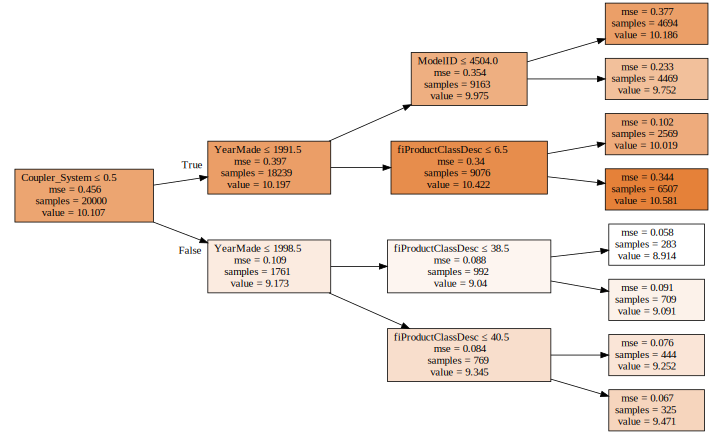

In [66]:
draw_tree(m.estimators_[0], df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [67]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

#last two are training r^2 and validation r^2 values respectivetly

[2.175583928816829e-17, 0.45557568674452303, 1.0, 0.6293456929818059]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use *bagging* of multiple trees to get more generalizable results.

## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [1]:
?RandomForestRegressor

Object `RandomForestRegressor` not found.


In [68]:
m = RandomForestRegressor(n_jobs=-1)

#See the bag of little bootstraps in notes
#by default you can see estimator =10 
#which means it will create 10 trees


#Extra regressor what differennce is it randomly tries a few 
#splits of few variables much faster more randomness
#co relation between trees should be minimize in order to 
#generalize

m.fit(X_train, y_train)
print_score(m)

[0.09278708985218918, 0.33527818198518833, 0.9811079866242297, 0.7992486105555128]


We'll grab the predictions for each individual tree, and look at one example.

In [69]:
#each tree is stored in underscore estimoators

preds = np.stack([t.predict(X_valid) for t in m.estimators_])
#above code gives me prediction for each model
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 9.10498,  9.3501 ,  9.04782,  9.21034,  9.04782,  9.01797,  9.15905,  9.25913,  9.04782,  9.04782,
         9.15905,  9.04782,  9.23503,  9.30565,  9.25913,  9.10498,  9.15905,  9.10498,  9.10498,  9.25913,
         9.6486 ,  9.10498,  9.04782,  9.61581,  9.51044,  9.15905,  9.10498,  9.10498,  9.04782,  9.10498,
         9.61581,  9.21034,  9.39266,  9.25913,  9.15905,  9.15905,  9.85219,  9.68034,  9.21034, 10.12663,
         9.10498,  9.10498,  8.9359 ,  8.9872 ,  9.04782,  9.04782,  9.15905,  9.15905,  9.3501 ,  9.10498,
         9.21034,  9.61581,  9.90349,  9.15905,  9.21034,  9.04782,  9.23503,  8.9872 ,  9.10498,  9.25913,
         9.04782,  9.61581,  9.82553,  9.61581,  9.3501 ,  9.61581,  8.9872 ,  8.9872 ,  9.21034,  8.92266,
         9.10498,  9.39266,  9.39266,  9.04782,  8.9359 ,  8.9872 ,  9.15905,  9.15905,  9.15905,  9.5819 ,
         9.30565,  9.15905,  9.68034,  9.15905,  9.61581,  9.15905,  9.21034,  9.10498,  9.15905,  8.92266,
         9.04782,  9.61581, 

In [70]:
preds.shape
#I have 12000 predictions for each of my 10 tree 


(100, 12000)

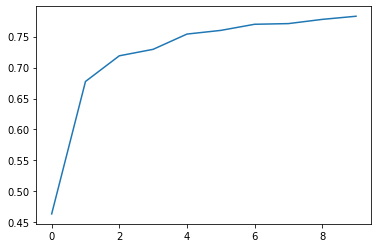

In [71]:
# for each of 10 trees take mean of all of predictions upto ith tree

#predict r^2 more bagging the more generalize
#Be ware the last point on upside should match 
#Bagging 1st window
#1:07:24 Lesson 2
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [72]:
#Doubling and compare r^2 value not help that much
#1:08
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10194735335454626, 0.35717396475996444, 0.9771936887089013, 0.7721717557691239]


In [73]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09576171195379067, 0.3400886805534549, 0.9798772681663903, 0.7934466093927793]


In [74]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09401761972544195, 0.3365465380860101, 0.9806035772847312, 0.7977268540885167]


### Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [75]:
#Some of rows which are not used during random sampling

#pass them as validation feature
#and so on
#different validation set for each tree

#oob_score=TRUE  it will create this thing for u
#one extra number at the end in print score will do this for you

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
#automated way to set hyperparameters
# 1:15 See Speeding up this  I just subset 30000 row and make 
#all trees with random 30000 rows
#Why dont i do all different 30000 each time 
#rather than bootstraping
#all the rows solution is below

[0.09592746795810594, 0.34169592235330415, 0.9798075461393012, 0.7914896744781865, 0.8547111515647277]


This shows that our validation set time difference is making an impact, as is model over-fitting.

## Reducing over-fitting

### Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: *subsampling*. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [76]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

len(X_train)


389125

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a *different* random subset per tree. That way, given enough trees, the model can still see *all* the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [77]:
#not bootstrap means not replacemet =TRUE

set_rf_samples(20000)



In [78]:
#reset_rf_samples() see this

In [79]:
#if you use this approACH oob=false

m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 25min 30s, sys: 8.34 s, total: 25min 38s
Wall time: 8min 16s
[0.07575074694707383, 0.2348381229925747, 0.9880075293218907, 0.9015115789442192, 0.9128555034772224]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [80]:
#Enogh tree will see everything

#increase estimator to 40 larger 0.86 to 0.876



m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


#Advantage lets say you have 120000 million rows 
#random forest will be forever you can use this solution instead
#So no dataset is too big

[0.07831280497504269, 0.23677751166809735, 0.9871825867920561, 0.8998781470797442, 0.9085797347172753]


### Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [81]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [82]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [83]:
#validation set score 2nd last answer ob is kast one

m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07830083257879722, 0.23596813610295694, 0.9871865055233483, 0.9005614693927686, 0.9086471526183416]


In [84]:
t=m.estimators_[0].tree_

In [85]:
dectree_max_depth(t)

47

In [86]:

#min sample means stop training the tree further when
# when your leaf node has 5 or less sample in possible 
#1,3,5,10,25

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.14075109332736402, 0.2336332778504421, 0.958596373689768, 0.9025195830202036, 0.9069926830350508]


In [87]:
t=m.estimators_[0].tree_

In [88]:
dectree_max_depth(t)

36

Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with `min_samples_leaf`) that we require some minimum number of rows in every leaf node. This has two benefits:

- There are less decision rules for each leaf node; simpler models should generalize better
- The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [89]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11492421721514817, 0.23290679151629295, 0.9723968951732281, 0.9031248742381092, 0.9085717774939043]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of *columns* for each *split*. We do this by specifying `max_features`, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [90]:
#every split we choose different subset of column rather than
#looking every possible column 0.5 randomly choose half of then
# pass sqrt lg  goog value is 0.5 log2 or sqrt ...see second 
# row root mean square error of log price drop from 0.234 to 0.2286

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11904000332721322, 0.22867074875402937, 0.9703843896979543, 0.90661670332302, 0.9116248183908767]


We can't compare our results directly with the Kaggle competition, since it used a different validation set (and we can no longer to submit to this competition) - but we can at least see that we're getting similar results to the winners based on the dataset we have.

The sklearn docs [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html) of different `max_features` methods with increasing numbers of trees - as you see, using a subset of features on each split requires using more trees, but results in better models:
![sklearn max_features chart](http://scikit-learn.org/stable/_images/sphx_glr_plot_ensemble_oob_001.png)

In [91]:
df_raw.fiProductClassDesc

0                  Wheel Loader - 110.0 to 120.0 Horsepower
1                  Wheel Loader - 150.0 to 175.0 Horsepower
2         Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...
3         Hydraulic Excavator, Track - 12.0 to 14.0 Metr...
4         Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...
                                ...                        
401120    Hydraulic Excavator, Track - 3.0 to 4.0 Metric...
401121    Hydraulic Excavator, Track - 3.0 to 4.0 Metric...
401122    Hydraulic Excavator, Track - 3.0 to 4.0 Metric...
401123    Hydraulic Excavator, Track - 2.0 to 3.0 Metric...
401124    Hydraulic Excavator, Track - 2.0 to 3.0 Metric...
Name: fiProductClassDesc, Length: 401125, dtype: category
Categories (74, object): [Backhoe Loader - 0.0 to 14.0 Ft Standard Diggi... < Backhoe Loader - 14.0 to 15.0 Ft Standard Digg... < Backhoe Loader - 15.0 to 16.0 Ft Standard Digg... < Backhoe Loader - 16.0 + Ft Standard Digging Depth ... Wheel Loader - 60.0 to 80.0 Horsepower < Wheel

In [92]:
df_raw.fiProductClassDesc.cat.categories

Index(['Backhoe Loader - 0.0 to 14.0 Ft Standard Digging Depth',
       'Backhoe Loader - 14.0 to 15.0 Ft Standard Digging Depth',
       'Backhoe Loader - 15.0 to 16.0 Ft Standard Digging Depth',
       'Backhoe Loader - 16.0 + Ft Standard Digging Depth',
       'Backhoe Loader - Unidentified',
       'Hydraulic Excavator, Track - 0.0 to 2.0 Metric Tons',
       'Hydraulic Excavator, Track - 11.0 to 12.0 Metric Tons',
       'Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons',
       'Hydraulic Excavator, Track - 14.0 to 16.0 Metric Tons',
       'Hydraulic Excavator, Track - 150.0 to 300.0 Metric Tons',
       'Hydraulic Excavator, Track - 16.0 to 19.0 Metric Tons',
       'Hydraulic Excavator, Track - 19.0 to 21.0 Metric Tons',
       'Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons',
       'Hydraulic Excavator, Track - 21.0 to 24.0 Metric Tons',
       'Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons',
       'Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons',
 

In [93]:
df_raw.fiProductClassDesc.cat.codes

0         58
1         61
2         38
3          7
4         39
          ..
401120    16
401121    16
401122    16
401123    12
401124    12
Length: 401125, dtype: int8